# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [1]:
## This cell: libraries and settings

import io
import logging
import sys
import pyndri
import time
import collections
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import defaultdict
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
import re
import pprint
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
## This cell: inverted index creation

index = pyndri.Index('index/')
token2id, id2token, id2df = index.get_dictionary()

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])
    
index = pyndri.Index('index/')
num_documents = index.maximum_document() - index.document_base()
dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

doc_ids = {}

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    doc_ids[int_doc_id] = ext_doc_id
    
    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 39.09302592277527 seconds.


In [3]:
## This cell: parsing of results and data structures

def parse_results(results_file):
    results_lines = [l.strip('\n') for l in open(results_file, 'r').readlines()]
    eval_measure = None
    results_by_scoring = defaultdict(lambda: defaultdict(dict))
    results_by_eval = defaultdict(lambda: defaultdict(dict))
    means = defaultdict(lambda: defaultdict(float))
    
    for line in results_lines:
        if line.startswith('MODEL:'):
            scoring_method = line.split(': ')[1]
            continue
        else:
            eval_measure, query, result = line.split()
            if query == 'all':
                means[eval_measure][scoring_method] = result
            else:
                results_by_scoring[scoring_method][eval_measure][int(query)] = float(result)
                
    for scoring_method in results_by_scoring.keys():
        for eval_measure in results_by_scoring[scoring_method].keys():
            for query, result in results_by_scoring[scoring_method][eval_measure].items():
                results_by_eval[eval_measure][scoring_method][query] = float(result)

    return means, results_by_scoring, results_by_eval
    
means_validation, scoring_dict_validation, eval_dict_validation = parse_results('results_validation.txt')
means_test, scoring_dict_test, eval_dict_test = parse_results('results_test.txt')
means_validation_df = pd.DataFrame.from_dict(means_validation)
means_test_df = pd.DataFrame.from_dict(means_test)

# dict with all language model names
language_models = {
    'absolute_discounting' : [setting for setting in list(means_test['ndcg_cut_10']) 
                              if setting.startswith('absolute_discounting')],
    'dirichlet' : [setting for setting in list(means_test['ndcg_cut_10']) 
                   if setting.startswith('dirichlet')],
    'jelinek_mercer' : [setting for setting in list(means_test['ndcg_cut_10']) 
                        if setting.startswith('jelinek_mercer')],
    'plm' : [setting for setting in list(means_test['ndcg_cut_10']) 
                        if setting.startswith('plm')]
}

# ranking functions list
ranking_functions = ['tfidf', 'BM25']

# dicts for easy pretty printing of eval measure, scoring method and (requested) settings
eval_measures = {
    'ndcg_cut_10' : 'NDCG@10',
    'map_cut_1000' : 'MAP@1000',
    'P_5' : 'Precision@5',
    'recall_1000' : 'Recall@1000'
}

scoring_methods = {
    'absolute_discounting' : 'Absolute Discounting',
    'dirichlet' : 'Dirichlet',
    'jelinek_mercer' : 'Jelinek-Mercer',
    'plm' : 'PLM',
    'tfidf' : 'TFIDF',
    'BM25' : 'BM25'
}

settings = {}
for setting in means_test['ndcg_cut_10']:
    settings[setting] = {}
    if setting.startswith('absolute_discounting'):
        settings[setting]['model'] = 'Absolute Discounting'
        settings[setting]['setting'] = "$\delta$ = " + "".join(re.findall(r'[0-9.]', setting))
    elif setting.startswith('jelinek_mercer'):
        settings[setting]['model'] = 'Jelinek-Mercer'
        settings[setting]['setting'] = "$\lambda$ = " + "".join(re.findall(r'[0-9.]', setting))
    elif setting.startswith('dirichlet'):
        settings[setting]['model'] = 'Dirichlet'
        settings[setting]['setting'] = "$\mu$ = " + "".join(re.findall(r'[0-9.]', setting))
        
requested_settings = {
    'jelinek_mercer': ('$\lambda$ = 0.1', '$\lambda$ = 0.5', '$\lambda$ = 0.9'),
    'dirichlet': ('$\mu$ = 500', '$\mu$ = 1000', '$\mu$ = 1500'),
    'absolute_discounting': ('$\delta$ = 0.1', '$\delta$ = 0.5', '$\delta$ = 0.9')
}

# all validation query ids
validation_queries = list(set([int(line.split(' ')[0]) 
                               for line in open('ap_88_89/qrel_validation', 'r').readlines()]))
# all test query ids
test_queries = list(set([int(line.split(' ')[0]) 
                         for line in open('ap_88_89/qrel_test', 'r').readlines()]))

# Plots and statistics on the validation set

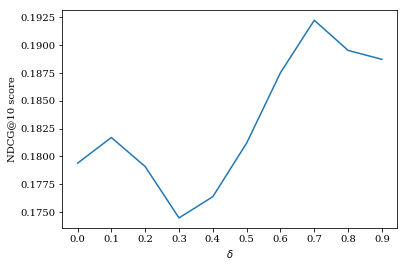

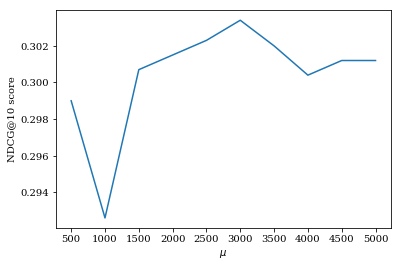

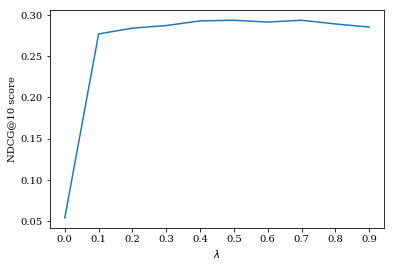

In [4]:
# plots for language models with different parameter settings on the validation set

for model in list(filter(lambda x: x != 'plm', language_models.keys())):
    pars = np.array([float(re.search(r'[0-9\.]+', setting).group(0)) for setting in language_models[model]])
    sorted_pars_idx = np.argsort(pars)
    model_means = np.array([means_validation['ndcg_cut_10'][setting] for setting in language_models[model]])
    parameter = ('$\mu$' if model == 'dirichlet' else '$\lambda$' if model == 'jelinek_mercer' else '$\delta$')
    plt.xticks(pars[sorted_pars_idx])
    plt.xlabel(parameter)
    plt.ylabel('NDCG@10 score')
    plt.plot(pars[sorted_pars_idx], model_means[sorted_pars_idx])
    plt.savefig('hyperparameter_plot_' + model + '.eps', format='eps', dpi=900)
    plt.show()

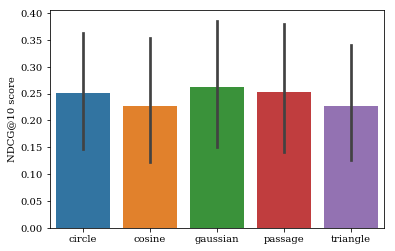

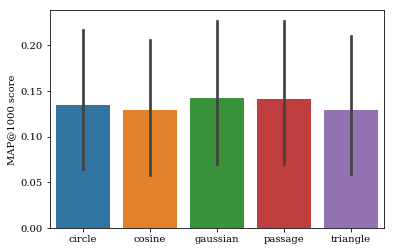

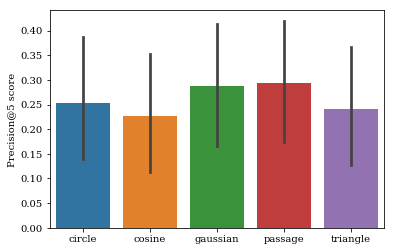

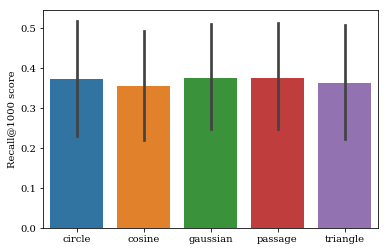

In [5]:
# plots for comparison between PLM kernels

for eval_measure in list(eval_dict_validation.keys()):
    data_things = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                    list(scoring_dict_validation[setting][eval_measure].values())) 
                          for setting in language_models['plm']])
    sns.barplot(data=[dat[1] for dat in data_things])
    plt.xticks(np.arange(len(data_things)), [thing[0] for thing in data_things])
    plt.ylabel(eval_measures[eval_measure] + ' score')
    plt.savefig('plm_kernels_' + eval_measures[eval_measure] + '.eps', format='eps', dpi=900)
    plt.show()

data_means = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                means_validation['ndcg_cut_10'][setting]) 
               for setting in language_models['plm']])
data_stds = sorted([(re.search(r'(?<=\_).*(?=\_)', setting).group(0), 
                np.std(list(scoring_dict_validation[setting]['ndcg_cut_10'].values()))) 
               for setting in language_models['plm']])

In [6]:
# t-tests and multiple comparisons between PLM kernels

p_vals = []
p_vals_corrected = defaultdict(dict)

for kernel_1, kernel_2 in combinations(language_models['plm'], 2):
    ttest_result = stats.ttest_rel(list(scoring_dict_validation[kernel_1]['ndcg_cut_10'].values()), 
                    list(scoring_dict_validation[kernel_2]['ndcg_cut_10'].values()))

    p_vals.append((ttest_result[1], (kernel_1, kernel_2)))
    
p_list = [p[0] for p in p_vals]
correction = multipletests(p_list, alpha=0.05, method='holm-sidak')

for i, p in enumerate(p_vals):
    kernel_1, kernel_2 = p[1]
    p_vals_corrected[kernel_1][kernel_2] = correction[1][i]
    
p_vals_corrected_df = pd.DataFrame.from_dict(p_vals_corrected)
p_vals_corrected_df

,plm_circle_3000,plm_cosine_3000,plm_gaussian_3000,plm_passage_3000
plm_cosine_3000,0.297993,NaN,NaN,NaN
plm_gaussian_3000,0.732586,0.297993,NaN,NaN
plm_passage_3000,0.982510,0.732586,0.732586,NaN
plm_triangle_3000,0.190842,0.982510,0.260973,0.732586


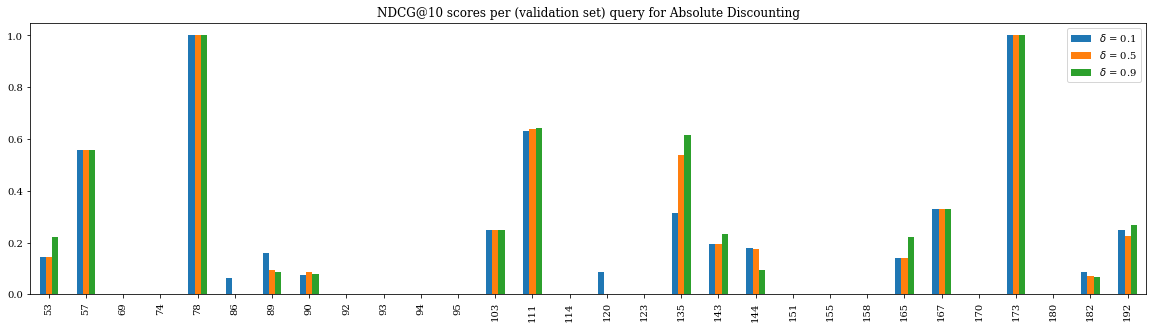

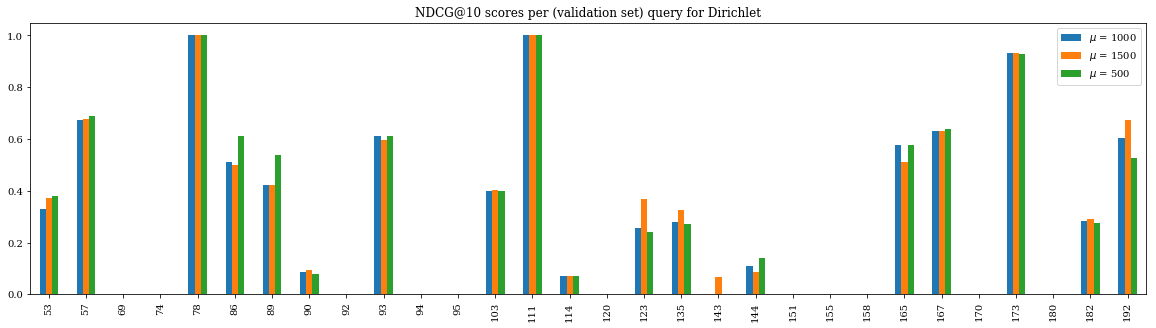

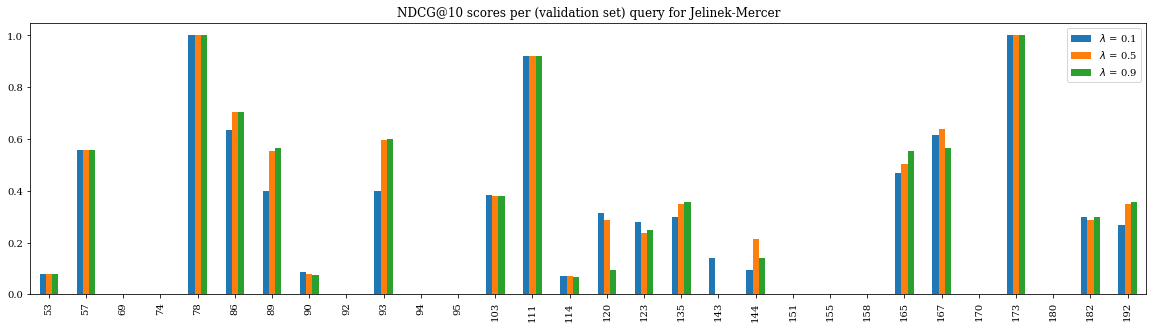

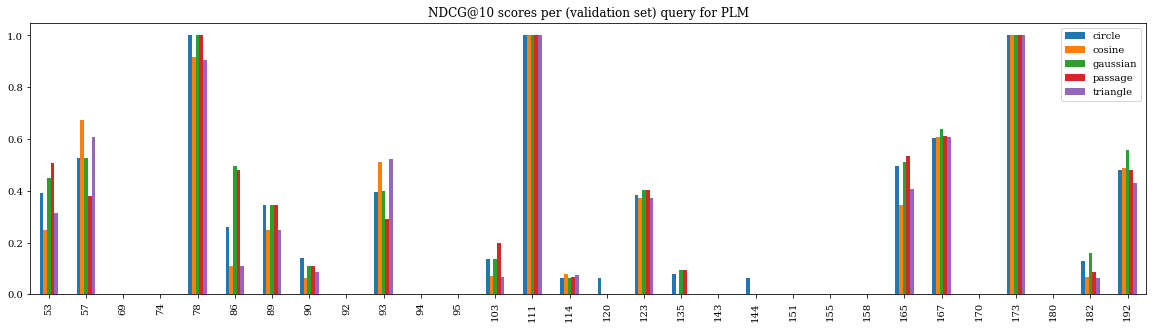

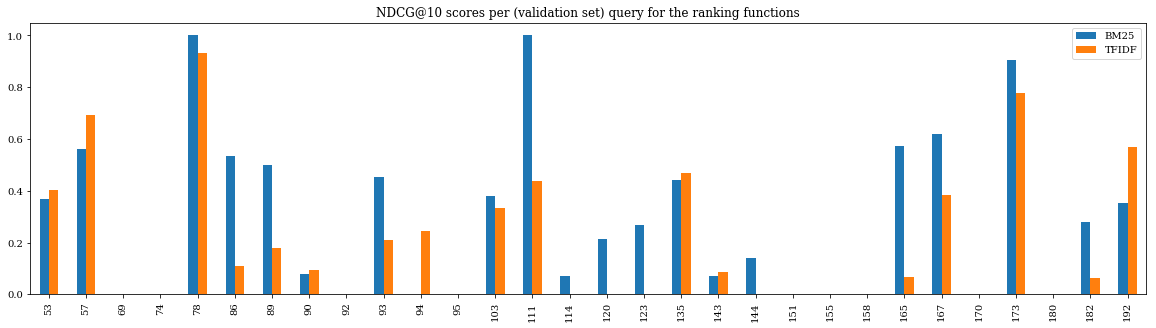

In [7]:
for model in language_models.keys():
    if model in ['absolute_discounting', 'jelinek_mercer', 'dirichlet']:
        dicts = { settings[setting]['setting'] : eval_dict_validation['ndcg_cut_10'][setting] 
                  for setting in language_models[model] if settings[setting]['setting'] in requested_settings[model] }
    else:
        dicts = { re.search(r'(?<=\_).*(?=\_)', setting).group(0) : eval_dict_validation['ndcg_cut_10'][setting] 
                  for setting in language_models[model] }
    
    ndcg_df = pd.DataFrame.from_dict(dicts) 
    ndcg_df.plot.bar(figsize=(20,5))
    plt.title('NDCG@10 scores per (validation set) query for ' + scoring_methods[model])
    plt.show()

    rank_dicts = { scoring_methods[ranking_function] : eval_dict_validation['ndcg_cut_10'][ranking_function] 
              for ranking_function in ranking_functions }
ndcg_df = pd.DataFrame.from_dict(rank_dicts) 
ndcg_df.plot.bar(figsize=(20,5))
plt.title('NDCG@10 scores per (validation set) query for the ranking functions')
plt.show()

# Plots and statistics on the test set

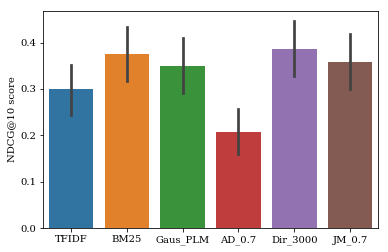

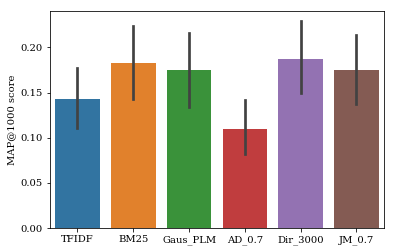

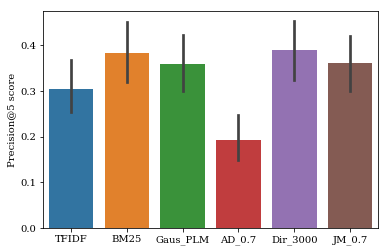

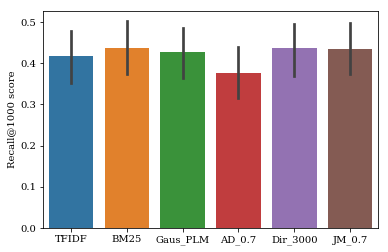

In [8]:
to_compare = { 
    'tfidf' : 'TFIDF',
    'BM25' : 'BM25', 
    'plm_gaussian_3000' : 'Gaus_PLM',
    'absolute_discounting0.7' : 'AD_0.7',
    'dirichlet3000' : 'Dir_3000',
    'jelinek_mercer0.5' : 'JM_0.7'}

for eval_measure in list(eval_dict_validation.keys()):
    data_things = [(to_compare[model], list(scoring_dict_test[model][eval_measure].values())) 
                          for model in to_compare.keys()]
    
    sns.barplot(data=[dat[1] for dat in data_things])
    plt.xticks(np.arange(len(data_things)), [thing[0] for thing in data_things])
    plt.ylabel(eval_measures[eval_measure] + ' score')
    plt.savefig('test_scoring_methods_' + eval_measures[eval_measure] + '.eps', format='eps', dpi=900)
    plt.show()

In [9]:
corrected_pvals_dfs = {}
for eval_measure in eval_measures.keys():
    p_vals = []
    p_vals_corrected = defaultdict(dict)

    for scoring_method_1, scoring_method_2 in combinations(list(to_compare.keys()), 2):
        ttest_result = stats.ttest_rel(list(scoring_dict_test[scoring_method_1][eval_measure].values()), 
                        list(scoring_dict_test[scoring_method_2][eval_measure].values()))

        p_vals.append((ttest_result[1], (scoring_method_1, scoring_method_2)))

    p_list = [p[0] for p in p_vals]
    correction = multipletests(p_list, alpha=0.05, method='holm-sidak')

    for i, p in enumerate(sorted(p_vals)):
        scoring_method_1, scoring_method_2 = p[1]
        if correction[1][i] < 0.05:
            p_vals_corrected[scoring_method_1][scoring_method_2] = '{:.2e}'.format(float(correction[1][i])) + ' *'
        else:
            p_vals_corrected[scoring_method_1][scoring_method_2] = '{:.2e}'.format(float(correction[1][i]))

    corrected_pvals_dfs[eval_measure] = pd.DataFrame.from_dict(p_vals_corrected)

In [10]:
corrected_pvals_dfs['ndcg_cut_10']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,9.45e-11 *
absolute_discounting0.7,9.05e-02,NaN,NaN,9.23e-05 *,4.06e-02 *
dirichlet3000,1.22e-09 *,2.09e-03 *,NaN,5.51e-01,1.15e-01
jelinek_mercer0.5,5.51e-01,1.14e-06 *,1.32e-07 *,6.62e-02,1.09e-01
plm_gaussian_3000,2.08e-11 *,NaN,NaN,NaN,8.10e-03 *


In [11]:
corrected_pvals_dfs['map_cut_1000']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,1.38e-08 *
absolute_discounting0.7,3.07e-03 *,NaN,NaN,4.05e-06 *,2.48e-08 *
dirichlet3000,8.34e-07 *,8.86e-05 *,NaN,4.20e-03 *,5.92e-02
jelinek_mercer0.5,9.78e-01,3.90e-03 *,8.25e-02,1.10e-03 *,1.11e-03 *
plm_gaussian_3000,3.57e-09 *,NaN,NaN,NaN,8.32e-07 *


In [12]:
corrected_pvals_dfs['P_5']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,1.76e-11 *
absolute_discounting0.7,1.25e-02 *,NaN,NaN,2.54e-03 *,1.38e-01
dirichlet3000,5.67e-10 *,1.39e-01,NaN,1.47e-07 *,4.03e-01
jelinek_mercer0.5,3.48e-01,1.29e-05 *,9.25e-01,3.48e-01,8.70e-01
plm_gaussian_3000,2.91e-10 *,NaN,NaN,NaN,3.48e-01


In [13]:
corrected_pvals_dfs['recall_1000']

,BM25,absolute_discounting0.7,dirichlet3000,plm_gaussian_3000,tfidf
BM25,NaN,NaN,NaN,NaN,2.26e-07 *
absolute_discounting0.7,2.28e-01,NaN,NaN,1.21e-02 *,7.86e-04 *
dirichlet3000,4.44e-01,1.81e-03 *,NaN,7.45e-01,3.00e-02 *
jelinek_mercer0.5,2.81e-07 *,5.07e-07 *,8.70e-08 *,3.04e-03 *,4.44e-01
plm_gaussian_3000,3.19e-06 *,NaN,NaN,NaN,3.10e-02 *


In [14]:
# finding 'most interesting' queries
zero_scores = defaultdict(dict)
tfidf_outperforming_bm25 = defaultdict(dict)
large_deltas = defaultdict(dict)

for query_id in test_queries:
    abs_disc_score = eval_dict_test['ndcg_cut_10']['absolute_discounting0.7'][query_id]
    dirichlet_score = eval_dict_test['ndcg_cut_10']['dirichlet3000'][query_id]
    jelinek_merc_score = eval_dict_test['ndcg_cut_10']['jelinek_mercer0.7'][query_id]
    plm_score = eval_dict_test['ndcg_cut_10']['plm_gaussian_3000'][query_id]
    tfidf_score = eval_dict_test['ndcg_cut_10']['tfidf'][query_id]
    bm25_score = eval_dict_test['ndcg_cut_10']['BM25'][query_id]
    
    all_scores = [abs_disc_score, dirichlet_score, jelinek_merc_score, plm_score, tfidf_score, bm25_score]
    
    if all([score == 0. for score in all_scores]):
        zero_scores['query'][query_id] = queries[str(query_id)]
    
    if tfidf_score > bm25_score:
        tfidf_outperforming_bm25['query'][query_id] = queries[str(query_id)]
        tfidf_outperforming_bm25['BM25 score'][query_id] = bm25_score
        tfidf_outperforming_bm25['TFIDF score'][query_id] = tfidf_score
        
    if abs(bm25_score - tfidf_score) > 0.5:
        large_deltas['query'][query_id] = queries[str(query_id)]
        large_deltas['BM25 score'][query_id] = bm25_score
        large_deltas['TFIDF score'][query_id] = tfidf_score
        
zero_scores_df = pd.DataFrame.from_dict(zero_scores)
tfidf_outperforming_bm25_df = pd.DataFrame.from_dict(tfidf_outperforming_bm25)
large_deltas_df = pd.DataFrame.from_dict(large_deltas)
pprint.pprint(zero_scores_df['query'].tolist())
pprint.pprint(tfidf_outperforming_bm25_df['query'].tolist())
large_deltas_df

['Information Retrieval Systems',
 'Natural Language Processing',
 'Politically Motivated Civil Disturbances',
 'U.S. Constitution - Original Intent',
 'FRG Political Party Positions',
 '1988 Presidential Candidates Platforms',
 'Criminal Actions Against Officers of Failed Financial Institutions',
 'U.S. Army Acquisition of Advanced Weapons Systems',
 'Controlling the Transfer of High Technology',
 '"Black Monday"',
 'U.S. Control of Insider Trading',
 'Find Innovative Companies',
 'Capacity of the U.S. Cellular Telephone Network',
 'RDT&E of New Cancer Fighting Drugs',
 'Alternatives to Traditional Cancer Therapies',
 'U.S.-U.S.S.R. Arms Control Agreements',
 'Diversification by Pacific Telesis',
 'The Effectiveness of Medical Products and Related Programs Utilized in the '
 'Cessation of Smoking.',
 'Difference of Learning Levels Among Inner City and More Suburban School '
 'Students',
 'Instances of Fraud Involving the Use of a Computer',
 'Efforts to Improve U.S. Schooling',
 'Lega

,BM25 score,TFIDF score,query
64,0.0000,0.6325,Hostage-Taking
68,0.5290,0.0000,Health Hazards from Fine-Diameter Fibers
71,0.7289,0.0000,Border Incursions
99,0.1331,0.6434,Iran-Contra Affair
148,0.5984,0.0948,Conflict in the Horn of Africa
174,1.0000,0.4164,Hazardous Waste Cleanup
